### Import Required Libraries

In [1]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (Fold-Change Only)

In [2]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "information_gain": "../results/information_gain_results.csv",  # Update path
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load Information Gain selected features
def load_information_gain_features(file_path, num_features=10):
    if os.path.exists(file_path):
        ig_data = pd.read_csv(file_path)

        # Ensure the required column exists
        if "Feature" in ig_data.columns and "Info_Gain_General" in ig_data.columns:
            selected_features = ig_data.nlargest(num_features, "Info_Gain_General")["Feature"].tolist()
            logging.info(f"Loaded top {num_features} Information Gain features.")
            return selected_features
        else:
            raise ValueError(f"Expected columns not found in {file_path}. Ensure 'Feature' and 'Info_Gain_General' exist.")
    else:
        raise FileNotFoundError(f"Information Gain feature selection file not found: {file_path}")


# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Select top Information Gain features
num_features_to_select = 500  # Change as needed
top_features = load_information_gain_features(file_paths["information_gain"], num_features=num_features_to_select)

# Ensure only valid miRNA features are selected (remove metadata like 'stage' and 'subtype' if present)
filtered_features = [feature for feature in top_features if feature.startswith("hsa-mir-")]

# Ensure the selected miRNAs are in the processed dataset
available_features = [feature for feature in filtered_features if feature in processed_data.columns]

# Final Check: Ensure count matches actual miRNAs displayed
logging.info(f"Total valid miRNAs used in classification: {len(available_features)}")

# Display selected miRNAs
print("\nSelected miRNAs for Classification:")
for i, miRNA in enumerate(available_features, 1):
    print(f"{i}. {miRNA}")

# Save cleaned miRNAs to a new CSV file
cleaned_miRNAs_df = pd.DataFrame(available_features, columns=["Selected_miRNAs"])
cleaned_miRNAs_df.to_csv("../results/cleaned_information_gain_miRNAs.csv", index=False)

print("\nProcessing complete. Selected features saved.")

2025-02-27 09:47:36,367 - INFO - Loaded top 500 Information Gain features.
2025-02-27 09:47:36,368 - INFO - Total valid miRNAs used in classification: 497



Selected miRNAs for Classification:
1. hsa-mir-4731
2. hsa-mir-3661
3. hsa-mir-4257
4. hsa-mir-5690
5. hsa-mir-181d
6. hsa-mir-4637
7. hsa-mir-526a-2
8. hsa-mir-5583-1
9. hsa-mir-203b
10. hsa-mir-509-1
11. hsa-mir-4501
12. hsa-mir-4802
13. hsa-mir-4471
14. hsa-mir-6880
15. hsa-mir-548ac
16. hsa-mir-381
17. hsa-mir-4740
18. hsa-mir-6849
19. hsa-mir-5088
20. hsa-mir-4513
21. hsa-mir-6720
22. hsa-mir-941-1
23. hsa-mir-17
24. hsa-mir-589
25. hsa-mir-4684
26. hsa-mir-3908
27. hsa-mir-5572
28. hsa-mir-6829
29. hsa-mir-4264
30. hsa-mir-5589
31. hsa-mir-466
32. hsa-mir-145
33. hsa-mir-770
34. hsa-mir-6768
35. hsa-mir-1273g
36. hsa-mir-6875
37. hsa-mir-3145
38. hsa-mir-572
39. hsa-mir-23c
40. hsa-mir-200c
41. hsa-mir-4277
42. hsa-mir-3144
43. hsa-mir-520f
44. hsa-mir-548i-1
45. hsa-mir-6090
46. hsa-mir-4472-1
47. hsa-mir-4756
48. hsa-mir-135a-2
49. hsa-mir-193b
50. hsa-mir-6796
51. hsa-mir-4794
52. hsa-mir-370
53. hsa-mir-3692
54. hsa-mir-6499
55. hsa-mir-1193
56. hsa-mir-19a
57. hsa-mir-1908


### Process Features & Labels for Multi-Output Classification (Information_Gain)

In [3]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again (use Information Gain selected features)
expression_values = filtered_data[available_features]  # Updated line

# Train-Test Split for Diagnosis Model (Healthy vs. Cancer)
X_train_diagnosis, X_test_diagnosis, y_train_diagnosis, y_test_diagnosis = train_test_split(
    expression_values, filtered_data["diagnosis"], test_size=0.2, random_state=42, stratify=filtered_data["diagnosis"]
)

# Train-Test Split for Stage & Subtype (Only Cancer Patients)
cancer_only = filtered_data["diagnosis"] == 1  # Filter out healthy cases
X_cancer = expression_values[cancer_only]
y_cancer = filtered_data[cancer_only][["stage", "subtype"]]

# Verify updated class distribution
print("\nUpdated class distribution for 'subtype':")
print(y_cancer["subtype"].value_counts())

# Check class distribution before stratifying
print("\nClass distribution in cancer dataset before splitting:")
print(y_cancer.value_counts())

# Check if all classes have at least 2 samples
min_class_size = y_cancer.apply(pd.Series.value_counts).min().min()

if min_class_size < 2:
    print("\nSome classes have too few samples for stratified splitting. Using random split instead.")
    stratify_option = None
else:
    stratify_option = y_cancer

# Define y for consistency
y = y_cancer  # Ensures `y_test` and `y_train` exist later

X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=stratify_option
)

# Scale features AFTER train-test split
scaler = StandardScaler()
X_train_diagnosis = scaler.fit_transform(X_train_diagnosis)
X_test_diagnosis = scaler.transform(X_test_diagnosis)

X_train_cancer = scaler.fit_transform(X_train_cancer)
X_test_cancer = scaler.transform(X_test_cancer)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Diagnosis Model - Training set: {X_train_diagnosis.shape}, Testing set: {X_test_diagnosis.shape}")
print(f"Stage & Subtype Model - Training set: {X_train_cancer.shape}, Testing set: {X_test_cancer.shape}")

print("\nUpdated Training set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nUpdated Training set class distribution (Stage & Subtype):")
print(y_train_cancer.value_counts())

print("\nUpdated Testing set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nUpdated Testing set class distribution (Stage & Subtype):")
print(y_test_cancer.value_counts())


Updated class distribution for 'subtype':
subtype
1    560
2    512
Name: count, dtype: int64

Class distribution in cancer dataset before splitting:
stage  subtype
1      1          312
       2          254
2      2          174
       1          134
3      1           90
       2           84
4      1           24
Name: count, dtype: int64

Updated Train-Test Split Information:
Diagnosis Model - Training set: (866, 497), Testing set: (217, 497)
Stage & Subtype Model - Training set: (857, 497), Testing set: (215, 497)

Updated Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Updated Training set class distribution (Stage & Subtype):
stage  subtype
1      1          250
       2          203
2      2          139
       1          107
3      1           72
       2           67
4      1           19
Name: count, dtype: int64

Updated Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Up

### Train-Test Split & Feature Scaling (Information Gain Only)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", available_features)  # Updated variable
print("Number of top features:", len(available_features))

# Ensure only selected Information Gain features are used
available_features = [feature for feature in available_features if feature in filtered_data.columns]
if not available_features:
    raise ValueError("No matching features found in processed data for the selected feature set.")

# Filter and Prepare Data
expression_values = filtered_data[available_features]  # Updated variable

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': available_features  # Updated variable
}


Initial data check:
Top features: ['hsa-mir-4731', 'hsa-mir-3661', 'hsa-mir-4257', 'hsa-mir-5690', 'hsa-mir-181d', 'hsa-mir-4637', 'hsa-mir-526a-2', 'hsa-mir-5583-1', 'hsa-mir-203b', 'hsa-mir-509-1', 'hsa-mir-4501', 'hsa-mir-4802', 'hsa-mir-4471', 'hsa-mir-6880', 'hsa-mir-548ac', 'hsa-mir-381', 'hsa-mir-4740', 'hsa-mir-6849', 'hsa-mir-5088', 'hsa-mir-4513', 'hsa-mir-6720', 'hsa-mir-941-1', 'hsa-mir-17', 'hsa-mir-589', 'hsa-mir-4684', 'hsa-mir-3908', 'hsa-mir-5572', 'hsa-mir-6829', 'hsa-mir-4264', 'hsa-mir-5589', 'hsa-mir-466', 'hsa-mir-145', 'hsa-mir-770', 'hsa-mir-6768', 'hsa-mir-1273g', 'hsa-mir-6875', 'hsa-mir-3145', 'hsa-mir-572', 'hsa-mir-23c', 'hsa-mir-200c', 'hsa-mir-4277', 'hsa-mir-3144', 'hsa-mir-520f', 'hsa-mir-548i-1', 'hsa-mir-6090', 'hsa-mir-4472-1', 'hsa-mir-4756', 'hsa-mir-135a-2', 'hsa-mir-193b', 'hsa-mir-6796', 'hsa-mir-4794', 'hsa-mir-370', 'hsa-mir-3692', 'hsa-mir-6499', 'hsa-mir-1193', 'hsa-mir-19a', 'hsa-mir-1908', 'hsa-mir-4638', 'hsa-mir-3124', 'hsa-mir-4466', '

### Train Multi-Output SVM Model (Information Gain Only)

In [5]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 10],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Train Diagnosis SVM (Healthy vs. Cancer)
print("\nTraining Diagnosis SVM...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train, y_train["diagnosis"])  # Use general training data

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test)

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", classification_report(y_test["diagnosis"], y_pred_diagnosis, zero_division=0))

# Train Stage SVM (Cancer Patients Only)
print("\nTraining Stage SVM...")
cancer_mask_train = y_train["diagnosis"] == 1
cancer_mask_test = y_test["diagnosis"] == 1

X_train_cancer = X_train[cancer_mask_train]
X_test_cancer = X_test[cancer_mask_test]

y_train_stage = y_train[cancer_mask_train]["stage"]
y_test_stage = y_test[cancer_mask_test]["stage"]

svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_stage)

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_stage, y_pred_stage, zero_division=0))

# Train Subtype SVM (Cancer Patients Only)
print("\nTraining Subtype SVM...")
y_train_subtype = y_train[cancer_mask_train]["subtype"]
y_test_subtype = y_test[cancer_mask_test]["subtype"]

svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_subtype)

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_subtype, y_pred_subtype, zero_division=0))



Training Diagnosis SVM...



Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg       0.13      0.25      0.17       215
weighted avg       0.28      0.53      

### Evaluate SVM Model (Information Gain)


-------------------- SVM (Information Gain) Results (Diagnosis) --------------------
Accuracy: 0.9907
Sensitivity (Recall): 0.5000
Specificity: 0.5000

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       213

    accuracy                           0.99       215
   macro avg       0.50      0.50      0.50       215
weighted avg       0.98      0.99      0.99       215


Confusion Matrix:
 [[  0   2]
 [  0 213]]

Diagnosis Confusion Matrix saved to ../results/svm_information_gain/svm_information_gain_diagnosis_confusion_matrix.png


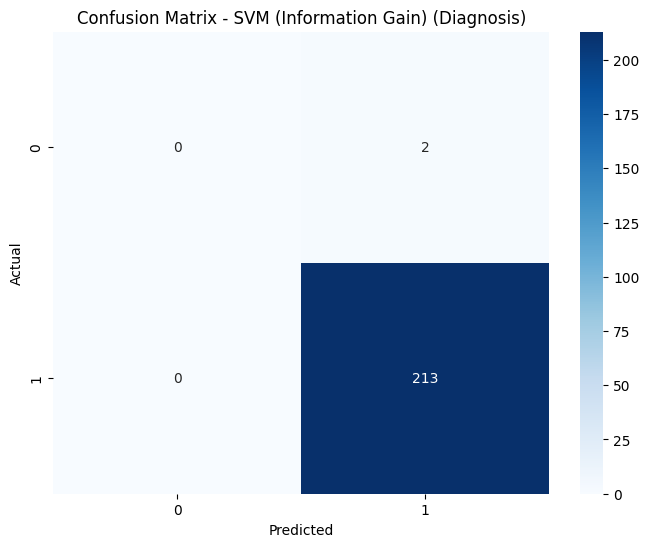


-------------------- SVM (Information Gain) Results (Stage) --------------------
Accuracy: 0.5256
Sensitivity (Recall): 0.2500
Specificity: 0.7500

Classification Report:
               precision    recall  f1-score   support

           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg       0.13      0.25      0.17       215
weighted avg       0.28      0.53      0.36       215


Confusion Matrix:
 [[113   0   0   0]
 [ 62   0   0   0]
 [ 35   0   0   0]
 [  5   0   0   0]]

Stage Confusion Matrix saved to ../results/svm_information_gain/svm_information_gain_stage_confusion_matrix.png


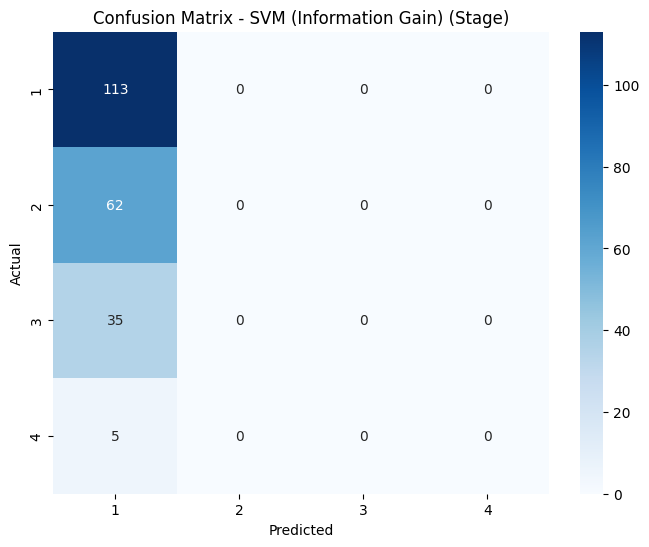


-------------------- SVM (Information Gain) Results (Subtype) --------------------
Accuracy: 0.5209
Sensitivity (Recall): 0.5000
Specificity: 0.5000

Classification Report:
               precision    recall  f1-score   support

           1       0.52      1.00      0.69       112
           2       0.00      0.00      0.00       103

    accuracy                           0.52       215
   macro avg       0.26      0.50      0.34       215
weighted avg       0.27      0.52      0.36       215


Confusion Matrix:
 [[112   0]
 [103   0]]

Subtype Confusion Matrix saved to ../results/svm_information_gain/svm_information_gain_subtype_confusion_matrix.png


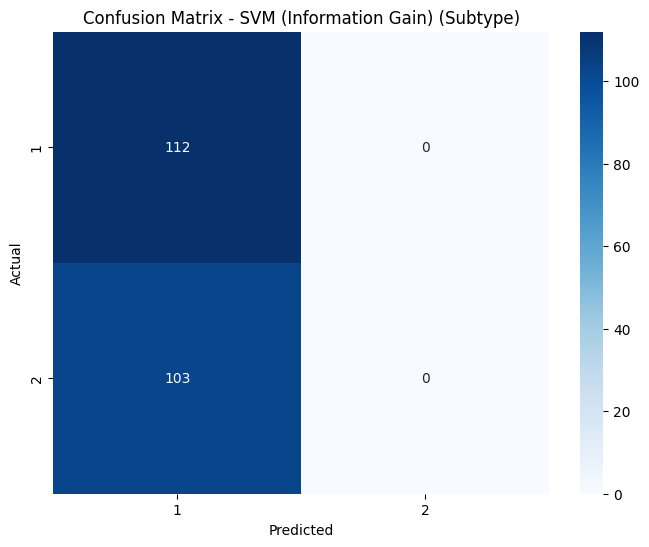


Diagnosis Feature Correlation Matrix saved to ../results/svm_information_gain/svm_information_gain_diagnosis_correlation_matrix.png

Diagnosis Feature Covariance Matrix saved to ../results/svm_information_gain/svm_information_gain_diagnosis_covariance_matrix.png

Stage Feature Correlation Matrix saved to ../results/svm_information_gain/svm_information_gain_stage_correlation_matrix.png

Stage Feature Covariance Matrix saved to ../results/svm_information_gain/svm_information_gain_stage_covariance_matrix.png

Subtype Feature Correlation Matrix saved to ../results/svm_information_gain/svm_information_gain_subtype_correlation_matrix.png


2025-02-27 09:51:07,749 - INFO - 
Model Evaluation Completed!
2025-02-27 09:51:07,750 - INFO - Diagnosis Accuracy: 0.9907
2025-02-27 09:51:07,750 - INFO - Stage Accuracy: 0.5256
2025-02-27 09:51:07,751 - INFO - Subtype Accuracy: 0.5209



Subtype Feature Covariance Matrix saved to ../results/svm_information_gain/svm_information_gain_subtype_covariance_matrix.png

Top 10 Features Based on Maximum Variance:
['hsa-mir-2681', 'hsa-mir-4733', 'hsa-mir-543', 'hsa-mir-548au', 'hsa-mir-5685', 'hsa-mir-3689b', 'hsa-mir-6129', 'hsa-mir-4731', 'hsa-mir-5684', 'hsa-mir-3138']
Top features saved to ../results/svm_information_gain/svm_information_gain_top_features.txt


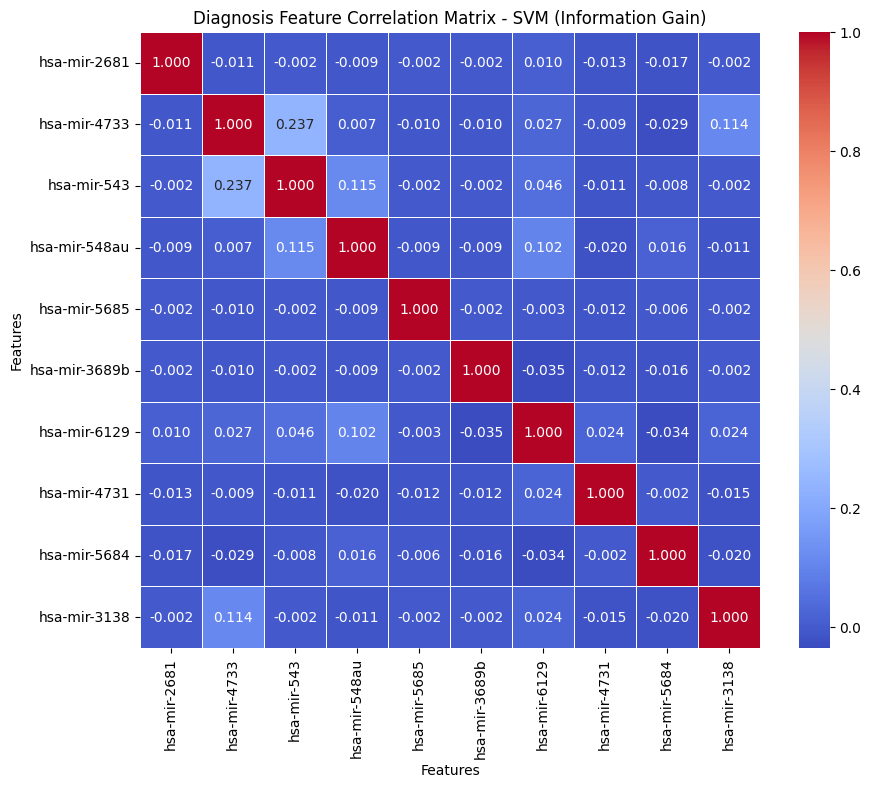

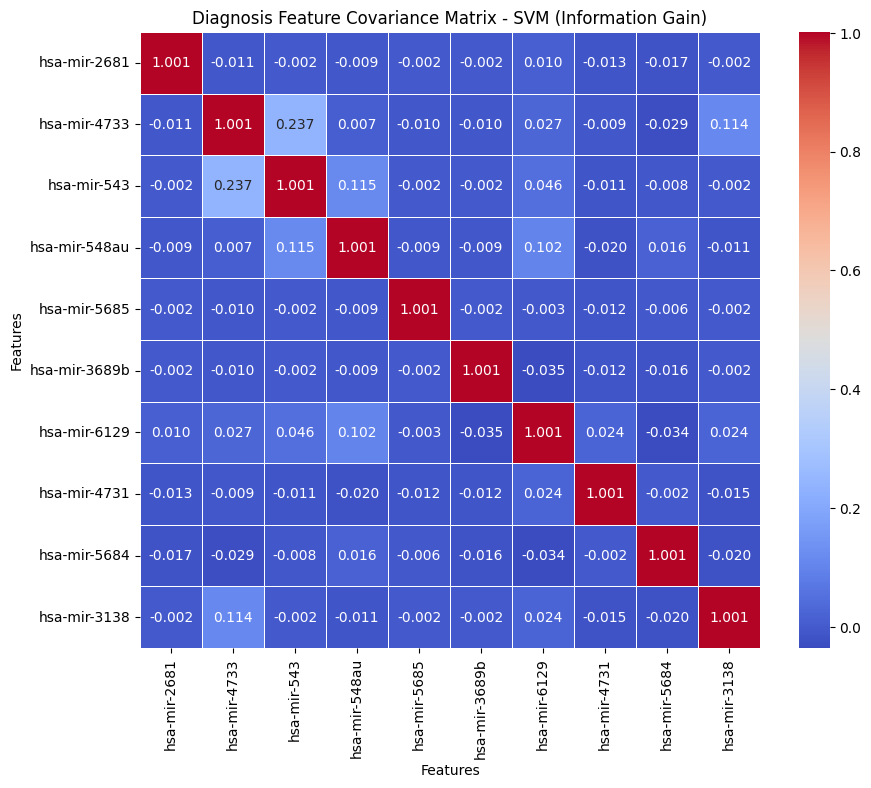

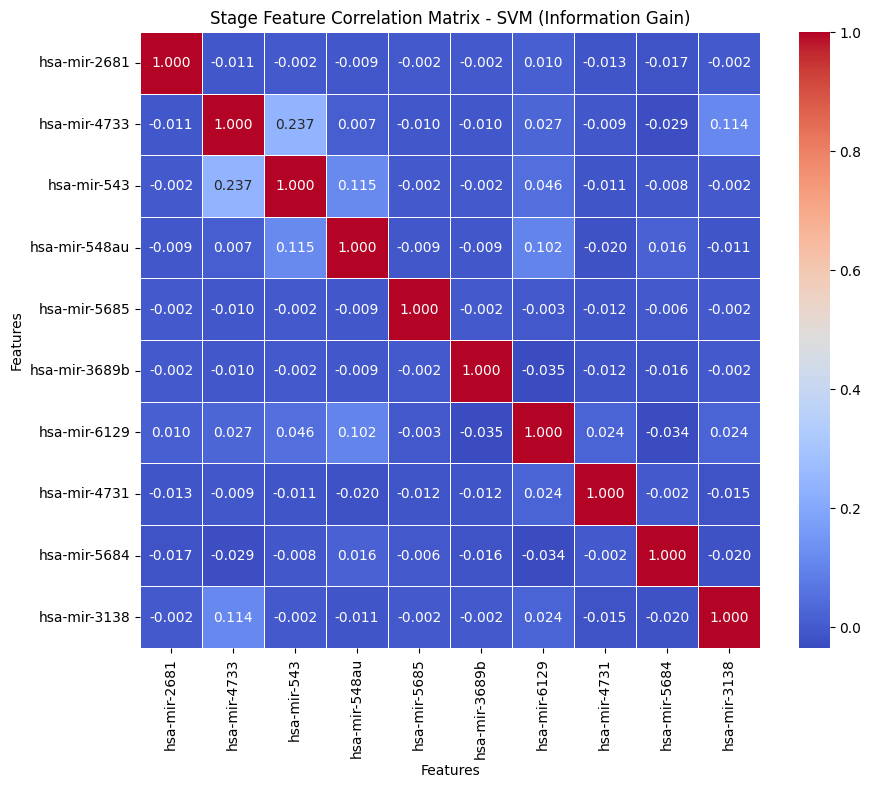

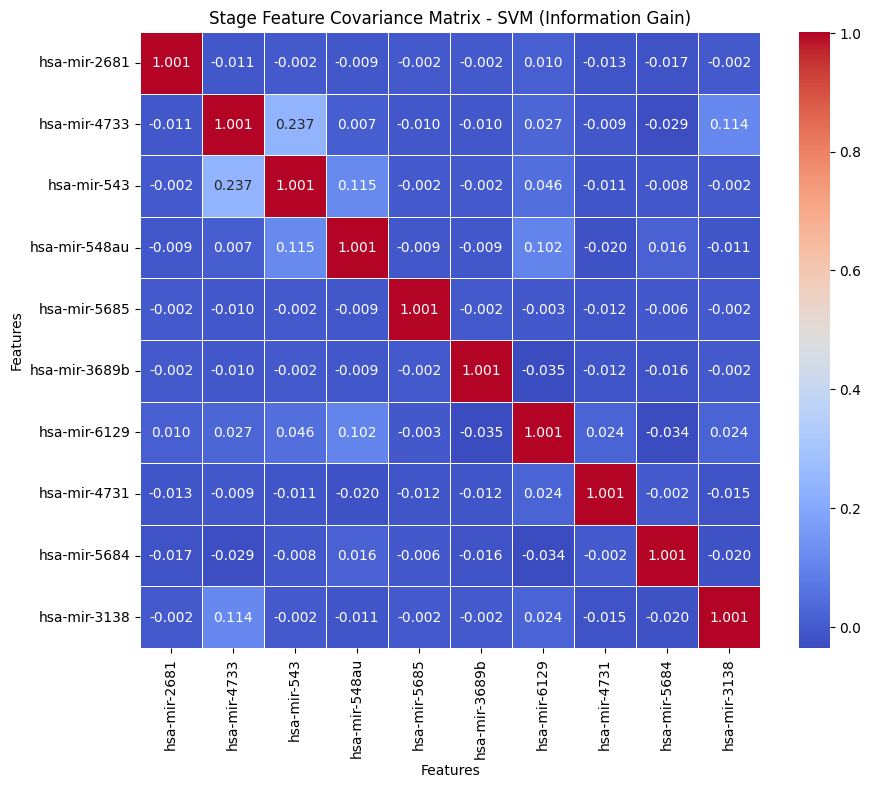

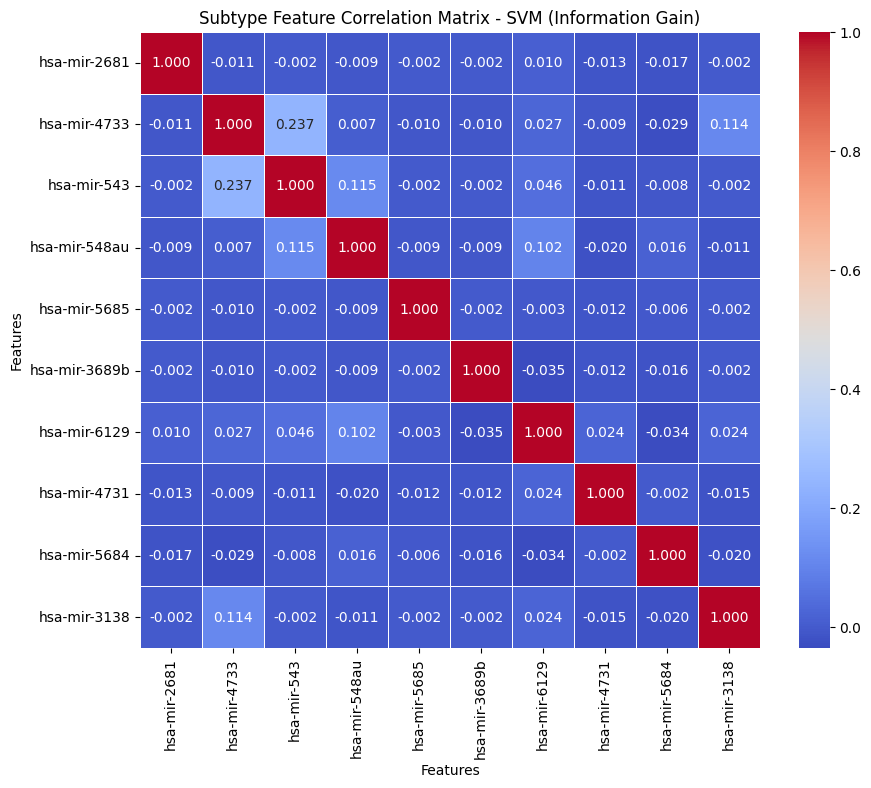

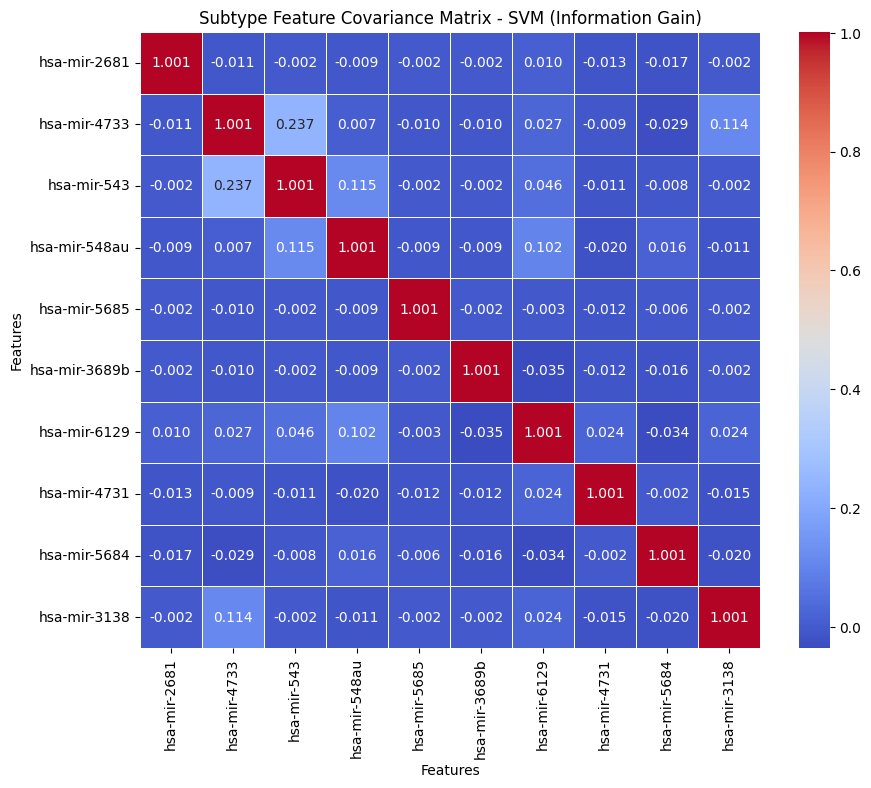

In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score

# Logging setup
import logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_svm_results(y_test_diagnosis, y_test_stage, y_test_subtype, 
                         y_pred_diagnosis, y_pred_stage, y_pred_subtype, 
                         X_train, top_features, model_name="SVM (Information Gain)", save_dir="../results/svm_information_gain/"):
    """
    Evaluate SVM performance for Diagnosis, Stage, and Subtype classification.
    - Generates accuracy scores, sensitivity, specificity.
    - Saves 9 images (3 Confusion Matrices + 3 Correlation Matrices + 3 Covariance Matrices).
    - Computes Sensitivity (Recall) and Specificity.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Ensure all labels and predictions have the same shape
    min_length = min(len(y_test_diagnosis), len(y_pred_diagnosis), 
                     len(y_test_stage), len(y_pred_stage), 
                     len(y_test_subtype), len(y_pred_subtype))

    # Trim data to match length
    y_test_diagnosis = y_test_diagnosis.iloc[:min_length]
    y_test_stage = y_test_stage.iloc[:min_length]
    y_test_subtype = y_test_subtype.iloc[:min_length]
    
    y_pred_diagnosis = y_pred_diagnosis[:min_length]
    y_pred_stage = y_pred_stage[:min_length]
    y_pred_subtype = y_pred_subtype[:min_length]

    # Convert predictions to DataFrame
    y_pred_df = pd.DataFrame({
        "diagnosis": y_pred_diagnosis,
        "stage": y_pred_stage,
        "subtype": y_pred_subtype
    }, index=y_test_diagnosis.index)

    # Evaluate Classification Performance
    results = {}
    for label, y_test, y_pred, name in [("diagnosis", y_test_diagnosis, y_pred_df["diagnosis"], "Diagnosis"),
                                        ("stage", y_test_stage, y_pred_df["stage"], "Stage"),
                                        ("subtype", y_test_subtype, y_pred_df["subtype"], "Subtype")]:
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        report = classification_report(y_test, y_pred, zero_division=0)

        # Compute Sensitivity (Recall)
        sensitivity = recall_score(y_test, y_pred, average="macro", zero_division=0)

        # Compute Specificity
        tn = cm.sum() - (cm.sum(axis=0) + cm.sum(axis=1) - np.diag(cm))  # True negatives
        fp = cm.sum(axis=0) - np.diag(cm)  # False positives
        specificity = np.nan_to_num((tn / (tn + fp)).mean())  # Prevent division errors

        results[label] = {
            "accuracy": accuracy,
            "sensitivity": sensitivity,
            "specificity": specificity,
            "confusion_matrix": cm.tolist(),
            "classification_report": report
        }

        print(f"\n{'-'*20} {model_name} Results ({name}) {'-'*20}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print("\nClassification Report:\n", report)
        print("\nConfusion Matrix:\n", cm)

        # Save Confusion Matrices
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted(y_test.unique()),
                    yticklabels=sorted(y_test.unique()))
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name} ({name})")

        cm_path = os.path.join(save_dir, f"svm_information_gain_{label}_confusion_matrix.png")
        plt.savefig(cm_path)
        print(f"\n{name} Confusion Matrix saved to {cm_path}")
        plt.show()

    # Ensure top_features matches X_train column count
    valid_features = top_features[:X_train.shape[1]]
    X_train_df = pd.DataFrame(X_train, columns=valid_features)

    # Feature Correlation & Covariance Matrices (Updated to 10x10)
    for label, y_test, name in [("diagnosis", y_test_diagnosis, "Diagnosis"),
                                ("stage", y_test_stage, "Stage"),
                                ("subtype", y_test_subtype, "Subtype")]:
        # Select **Top 10** Highest Variance Features
        top_corr_features = X_train_df.var().sort_values(ascending=False).index[:10]
        corr_matrix = X_train_df[top_corr_features].corr()
        cov_matrix = X_train_df[top_corr_features].cov()

        # Plot correlation matrix (10x10)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".3f", linewidths=0.5,
                    xticklabels=top_corr_features, yticklabels=top_corr_features)
        plt.xlabel("Features")
        plt.ylabel("Features")
        plt.title(f"{name} Feature Correlation Matrix - {model_name}")

        corr_path = os.path.join(save_dir, f"svm_information_gain_{label}_correlation_matrix.png")
        plt.savefig(corr_path, bbox_inches='tight', dpi=300)
        print(f"\n{name} Feature Correlation Matrix saved to {corr_path}")
        
        # Plot covariance matrix (10x10)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cov_matrix, cmap='coolwarm', annot=True, fmt=".3f", linewidths=0.5,
                    xticklabels=top_corr_features, yticklabels=top_corr_features)
        plt.xlabel("Features")
        plt.ylabel("Features")
        plt.title(f"{name} Feature Covariance Matrix - {model_name}")

        cov_path = os.path.join(save_dir, f"svm_information_gain_{label}_covariance_matrix.png")
        plt.savefig(cov_path, bbox_inches='tight', dpi=300)
        print(f"\n{name} Feature Covariance Matrix saved to {cov_path}")

    # Identify & Save Top 10 Features Based on Variance
    top_10_features = X_train_df.var().sort_values(ascending=False).index[:10].tolist()
    print("\nTop 10 Features Based on Maximum Variance:")
    print(top_10_features)

    feature_path = os.path.join(save_dir, "svm_information_gain_top_features.txt")
    with open(feature_path, "w") as f:
        for feature in top_10_features:
            f.write(f"{feature}\n")
    print(f"Top features saved to {feature_path}")

    # Log evaluation metrics
    logging.info(f"\nModel Evaluation Completed!")
    logging.info(f"Diagnosis Accuracy: {results['diagnosis']['accuracy']:.4f}")
    logging.info(f"Stage Accuracy: {results['stage']['accuracy']:.4f}")
    logging.info(f"Subtype Accuracy: {results['subtype']['accuracy']:.4f}")

    # Return All Metrics as a Dictionary
    return {
        "diagnosis": results["diagnosis"],
        "stage": results["stage"],
        "subtype": results["subtype"],
        "top_features": top_10_features
    }

# Run Evaluation
save_dir = "../results/svm_information_gain/"
metrics_information_gain = evaluate_svm_results(y_test_diagnosis, y_test_stage, y_test_subtype, 
                                                y_pred_diagnosis, y_pred_stage, y_pred_subtype, 
                                                X_train, top_features, model_name="SVM (Information Gain)", save_dir=save_dir)

### Save Everything & Finalize the Pipeline (Information Gain)

In [7]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory for Information Gain Results
output_dir = "../results/svm_information_gain/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Ensure `y_test` is properly assigned
if "y_test_diagnosis" not in locals() or "y_test_stage" not in locals() or "y_test_subtype" not in locals():
    raise ValueError("One of `y_test_diagnosis`, `y_test_stage`, or `y_test_subtype` is missing. Ensure variables are assigned before running this block.")

# Ensure `y_pred` exist for all models
if "y_pred_diagnosis" not in locals() or "y_pred_stage" not in locals() or "y_pred_subtype" not in locals():
    raise ValueError("One of the `y_pred_diagnosis`, `y_pred_stage`, or `y_pred_subtype` predictions is missing. Ensure models have made predictions.")

# Ensure predictions have the same length as `y_test`
min_length = min(len(y_test_diagnosis), len(y_pred_diagnosis), len(y_test_stage), len(y_pred_stage), len(y_test_subtype), len(y_pred_subtype))

y_test_diagnosis = y_test_diagnosis.iloc[:min_length].reset_index(drop=True)
y_test_stage = y_test_stage.iloc[:min_length].reset_index(drop=True)
y_test_subtype = y_test_subtype.iloc[:min_length].reset_index(drop=True)

y_pred_diagnosis = y_pred_diagnosis[:min_length]
y_pred_stage = y_pred_stage[:min_length]
y_pred_subtype = y_pred_subtype[:min_length]

# Save Predictions & Actual Labels
y_pred_df = pd.DataFrame({
    "diagnosis": y_pred_diagnosis,
    "stage": y_pred_stage,
    "subtype": y_pred_subtype
}, index=y_test_diagnosis.index)

predictions_path = os.path.join(output_dir, "svm_information_gain_predictions.csv")
y_pred_df.to_csv(predictions_path, index=False)
logging.info(f"Predictions saved to {predictions_path}")
print(f"Predictions saved to {predictions_path}")

actual_labels_path = os.path.join(output_dir, "svm_information_gain_actual_labels.csv")
y_test_combined = pd.DataFrame({
    "diagnosis": y_test_diagnosis,
    "stage": y_test_stage,
    "subtype": y_test_subtype
})
y_test_combined.to_csv(actual_labels_path, index=False)
logging.info(f"Actual labels saved to {actual_labels_path}")
print(f"Actual labels saved to {actual_labels_path}")

# Save Experiment Metadata
metadata = {
    "diagnosis_hyperparameters": grid_diagnosis.best_params_ if "grid_diagnosis" in locals() else "N/A",
    "stage_hyperparameters": grid_stage.best_params_ if "grid_stage" in locals() else "N/A",
    "subtype_hyperparameters": grid_subtype.best_params_ if "grid_subtype" in locals() else "N/A",
    "diagnosis_accuracy": metrics["diagnosis"]["accuracy"] if "diagnosis" in metrics else "N/A",
    "stage_accuracy": metrics["stage"]["accuracy"] if "stage" in metrics else "N/A",
    "subtype_accuracy": metrics["subtype"]["accuracy"] if "subtype" in metrics else "N/A",
    "diagnosis_sensitivity": metrics["diagnosis"].get("sensitivity", "N/A"),
    "stage_sensitivity": metrics["stage"].get("sensitivity", "N/A"),
    "subtype_sensitivity": metrics["subtype"].get("sensitivity", "N/A"),
    "diagnosis_specificity": metrics["diagnosis"].get("specificity", "N/A"),
    "stage_specificity": metrics["stage"].get("specificity", "N/A"),
    "subtype_specificity": metrics["subtype"].get("specificity", "N/A"),
    "diagnosis_confusion_matrix": metrics["diagnosis"].get("confusion_matrix", "N/A"),
    "stage_confusion_matrix": metrics["stage"].get("confusion_matrix", "N/A"),
    "subtype_confusion_matrix": metrics["subtype"].get("confusion_matrix", "N/A"),
    "train_set_size": X_train.shape[0] if "X_train" in locals() else "N/A",
    "test_set_size": X_test.shape[0] if "X_test" in locals() else "N/A"
}

metadata_path = os.path.join(output_dir, "svm_information_gain_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")
print(f"Metadata saved to {metadata_path}")

# Save Separate Models for Diagnosis, Stage & Subtype
if "best_svm_diagnosis" in locals():
    model_diagnosis_path = os.path.join(output_dir, "svm_information_gain_diagnosis_model.pkl")
    joblib.dump(best_svm_diagnosis, model_diagnosis_path)
    logging.info(f"Diagnosis model saved to {model_diagnosis_path}")
    print(f"Diagnosis model saved to {model_diagnosis_path}")
else:
    logging.warning("`best_svm_diagnosis` is missing. The model was not saved.")

if "best_svm_stage" in locals():
    model_stage_path = os.path.join(output_dir, "svm_information_gain_stage_model.pkl")
    joblib.dump(best_svm_stage, model_stage_path)
    logging.info(f"Stage model saved to {model_stage_path}")
    print(f"Stage model saved to {model_stage_path}")
else:
    logging.warning("`best_svm_stage` is missing. The model was not saved.")

if "best_svm_subtype" in locals():
    model_subtype_path = os.path.join(output_dir, "svm_information_gain_subtype_model.pkl")
    joblib.dump(best_svm_subtype, model_subtype_path)
    logging.info(f"Subtype model saved to {model_subtype_path}")
    print(f"Subtype model saved to {model_subtype_path}")
else:
    logging.warning("`best_svm_subtype` is missing. The model was not saved.")

print("\nAll results successfully saved. The SVM pipeline using Information Gain features is complete.")

2025-02-27 09:51:43,779 - INFO - Predictions saved to ../results/svm_information_gain/svm_information_gain_predictions.csv
2025-02-27 09:51:43,781 - INFO - Actual labels saved to ../results/svm_information_gain/svm_information_gain_actual_labels.csv


Predictions saved to ../results/svm_information_gain/svm_information_gain_predictions.csv
Actual labels saved to ../results/svm_information_gain/svm_information_gain_actual_labels.csv


NameError: name 'metrics' is not defined